#Point cloud section

Getting either a horizontal or a vertical section of a point cloud is quite a common job in geoinformatics these days. There is a wide variety of software to complete this task. For the very first trials the open-source [CloudCompare](https://www.danielgm.net/cc/) would be an option. Both graphical and command line interfaces are available.

In this tutorial some basic python scripts are presented in order to be able to set up your own preferences. 

First, load the point cloud into a numpy array. The file contains UTM easting and northing coordinates as well as elevation above mean sea level. Fields are separetd by comma and there is no header.

In [2]:
import numpy as np
pc = np.loadtxt('https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/lidar.txt', delimiter=',') # load point cloud from text file

Check out the number of points loaded and get the minimum and maximum of the elevations

In [90]:
pc.shape[0], np.min(pc[:,2]), np.max(pc[:,2])

(51150, 933.31, 1139.11)

Getting a horizontal section is nothing else just filter out those points which height differs from the section plane within a given tolerance.  

In [77]:
tol = 1 # tolerance
coo = 1100 # elevation of section plane
sec = pc[np.absolute(pc[:, 2] - coo) < tol]

Check out the number of points in the section:

In [35]:
sec.shape[0]

896

and plot the points in a top view

Text(0.5, 1.0, 'section at level 1100 m')

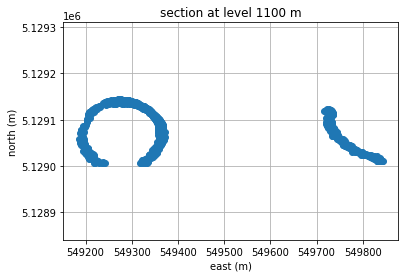

In [42]:
import matplotlib.pyplot as plt
plt.plot(sec[:,0], sec[:,1], 'o')
plt.xlabel('east (m)')
plt.ylabel('north (m)')
plt.axis('equal')
plt.grid('on')
plt.title('section at level ' + str(coo) + ' m')

Another common job worth discussing in this tutorial is when a vertical section of the point cloud along a line is needed to create. Without going into the details, this job will be completed using homogenous coordinates. The section line is defined by the coordinates of two points on the line.


In [69]:
e1 = 549400; n1 = 5128900 #first point of the section line
e2 = 549200; n2 = 5129300 #second point of the section line

At first, we need to define a function to set up the line equation. In case a point is exactly on the line, the point coordinates fulfill the equations.

In [70]:
from math import hypot
def vplain(x1, y1, x2, y2):
  """ set up line equation
  vp[0] * x + vp[1] * y + vp[2] = 0

  x1, y1 - horizontal coordinates of the start point of the section
  x2, y2 - horizontal coordinates of the end point of the section
  returns a numpy array with coefficients of the vertical plane
  """

  vp = np.zeros((3,))
  vp[0] = y1 - y2
  vp[1] = x2 - x1
  vp[2] = x1 * y2 - x2 * y1
  vp = vp / hypot(vp[0], vp[1]) # normalize
  return vp

vplain(e1, n1, e2, n2)

array([-8.94427191e-01, -4.47213595e-01,  2.78511211e+06])

At second, we need to filter out those points which distance from the section line is within the tolerance. Distance is computed by multiplying the point cloud and the array with the coefficients of the line. Strange as it may sound, but now the distance has a sign. The sign says whether a specific point is on the left or the right side of the line. For filtering we use the absolute value of the distances. 

In [71]:
def section(pc, x1, y1, x2, y2, tol):
  """ Select point from a point cloud near to a line

  pc - point cloud in a numpy array
  x1, y1 - horizontal coordinates of the start point of the section
  x2, y2 - horizontal coordinates of the end point of the section
  tol - tolerance distance from the section
  returns a numpy array with points near to the section
  """
  pc1 = pc.copy()
  pc1[:, 2] = 1 # change to homogenous coordinates
  vp = vplain(x1, y1, x2, y2) # equation of vertical plain
  sec = pc[np.abs(np.dot(pc1, vp)) < tol] # select points close to the section

  return sec

check out the number of points in the section

In [78]:
sec = section(pc, e1, n1, e2, n2, tol)
sec.shape[0]

96

Plot the points in a top view

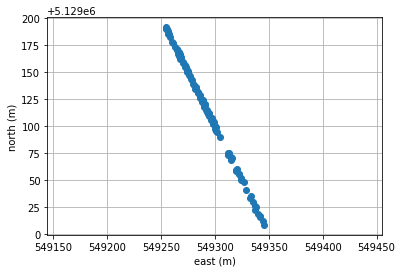

In [79]:
plt.plot(sec[:,0], sec[:,1], 'o')
plt.xlabel('east (m)')
plt.ylabel('north (m)')
plt.axis('equal')
plt.grid('on')

In order to plot a section view, we need to transform section points into a system defined by the section line. To put it another way, the transformation matrix contains a shift to the first point of the section line and a rotation by the whole circle bearing of the line.

In [80]:
def tr(e1, n1, e2, n2):
  """ set up transformation matrix for homogenous coordinates

  Parameters:
  e1, n1 - start point of the section line
  e2, n2 - end point of the section section line
  returns the transformation matrix
  """
  de = e2 - e1
  dn = n2 - n1

  d = hypot(de, dn) # distance
  r = de / d # sin
  m = dn / d # cos
  return np.dot(np.array([[1, 0, 0], [0, 1, 0], [-e1, -n1, 1]]),
                np.array([[m, r, 0], [-r, m, 0], [0, 0, 1]]))
  

Then apply the transformation to the sction points. 

In [82]:
# transformation matrix
trm = tr(e1, n1, e2, n2)
# make a copy of section points for homogenous transformation
pc1 = sec.copy()
pc1[:, 2] = 1
pc1 = np.dot(pc1, trm) # rotate points into the section plain
pc1[:, 2] = sec[:, 2] # copy back elevations to transformed points

Plot the points in a section view

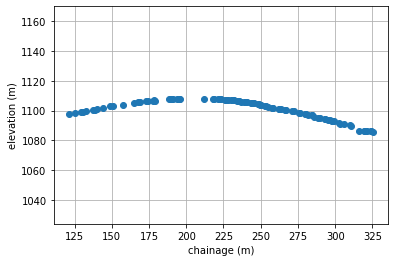

In [88]:
plt.plot(pc1[:,1], pc1[:,2], 'o')
plt.xlabel('chainage (m)')
plt.ylabel('elevation (m)')
plt.axis('equal')
plt.grid('on')